In [7]:
%matplotlib inline

from joblib import dump, load
import itertools
import json
import math
import os
import random
import time
from typing import Callable, Dict, List

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# scikit-learn
import sklearn
from sklearn.base import clone
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, \
    f1_score, fbeta_score, log_loss, make_scorer, precision_recall_fscore_support, \
    precision_score, precision_recall_curve, recall_score
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Models
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor


# NLP
import gc
import re
import string
import operator
from collections import defaultdict



# Configure options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 11

random.seed(random_state)
np.random.seed(random_state)

In [14]:
root = '/home/jovyan/work'

# Overview

In [237]:
ch = pd.read_csv(root + '/Downloads/diversity/company_hierarchy.csv')
emp = pd.read_csv(root + '/Downloads/diversity/employee.csv')

In [16]:
ch.describe()

,employee_id,boss_id
count,10000.000000,9999.000000
mean,100001.855800,103299.980498
std,57500.488641,57508.798817
min,40.000000,79.000000
25%,50574.500000,55883.000000
50%,99244.500000,102712.000000
75%,149748.500000,152288.000000
max,199956.000000,199950.000000


In [18]:
ch.head(5)

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [17]:
emp.describe()

,employee_id,signing_bonus,salary,yrs_experience
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,100001.855800,0.301400,189111.800000,3.875200
std,57500.488641,0.458889,88973.796898,3.107409
min,40.000000,0.000000,60000.000000,1.000000
25%,50574.500000,0.000000,110000.000000,2.000000
50%,99244.500000,0.000000,182000.000000,3.000000
75%,149748.500000,1.000000,255000.000000,5.000000
max,199956.000000,1.000000,700000.000000,34.000000


In [19]:
emp.head(5)

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [28]:
def get_missing_stats(df, columns):
    dtypes = df.dtypes
    missing_cols = []
    for column in columns:
        missing = df[df[column].isnull()]

        if len(missing) > 0:
            missing_cols.append({'column': column,
                                 'dtype': str(dtypes[column]),
                                 'num_missing': len(missing),
                                 'num_not_missing': len(df) - len(missing),
                                 'pct_missing': len(missing) / len(df)})
    if len(missing_cols) > 0:
        return pd.DataFrame(missing_cols).sort_values(by='pct_missing', ascending=False)
    return pd.DataFrame()

## Employees

In [27]:
get_missing_stats(emp, emp.columns)

""


In [29]:
emp[emp.duplicated()]

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience


In [31]:
emp.dtypes

employee_id         int64
signing_bonus       int64
salary            float64
degree_level       object
sex                object
yrs_experience      int64
dtype: object

In [38]:
for col in emp.columns:
    print(col, len(emp[col].unique()))

employee_id 10000
signing_bonus 2
salary 344
degree_level 4
sex 2
yrs_experience 31


In [39]:
for col in ['signing_bonus', 'degree_level', 'sex']:
    print(emp[col].unique())

[0 1]
['Master' 'Bachelor' 'High_School' 'PhD']
['M' 'F']


## Company hierarchy

In [22]:
get_missing_stats(ch, ch.columns)

,column,dtype,num_missing,num_not_missing,pct_missing
0,boss_id,float64,1,9999,0.0001


In [23]:
ch[ch['boss_id'].isnull()]

,employee_id,boss_id,dept
2427,61554,NaN,CEO


In [115]:
ch.loc[ch['boss_id'].isnull(), 'boss_id'] = -1

In [116]:
ch[ch['boss_id'].isnull()]

,employee_id,boss_id,dept
employee_id,,,


In [26]:
ch[ch.duplicated()]

,employee_id,boss_id,dept


In [30]:
ch.dtypes

employee_id      int64
boss_id        float64
dept            object
dtype: object

In [40]:
for col in ch.columns:
    print(col, len(ch[col].unique()))

employee_id 10000
boss_id 1000
dept 5


# Features

## Levels 

In [65]:
ch = ch.set_index('employee_id', drop=False)

employee_id
46456      0.0
104708     0.0
120853     0.0
142630    16.0
72711      0.0
          ... 
173414     0.0
194688     0.0
11698      0.0
144338     0.0
count      1.0
Name: count, Length: 10001, dtype: float64

In [89]:
ch.groupby('boss_id').count()

,employee_id,dept,num_ic_reports
boss_id,,,
79.0,9,9,9
90.0,8,8,8
252.0,10,10,10
742.0,17,17,17
754.0,16,16,16
...,...,...,...
198879.0,13,13,13
198893.0,2,2,2
199184.0,15,15,15


In [358]:
ch = pd.read_csv(root + '/Downloads/diversity/company_hierarchy.csv')
ch = ch.set_index('employee_id', drop=False)
ch['level'] = 'IC'
ch['num_direct_reports'] = 0
ch['num_indirect_reports'] = 0

def get_num_reports(df, level):
    col = 'num_direct_reports'
    count_direct_reports = df[['boss_id']].copy()
    count_direct_reports[col] = 1
    count_direct_reports = count_direct_reports.groupby('boss_id')[[col]].count()
    count_direct_reports['level'] = level
    count_direct_reports.index.name = 'employee_id'
    return count_direct_reports

levels = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
for idx, level in enumerate(levels):
    if level == 'IC':
        reports = get_num_reports(ch, level)
    else:
        prev_level = levels[idx - 1]
        reports = get_num_reports(ch[ch['level'] == f'{prev_level}'], level)
    
    ch.update(reports)


In [198]:
ch.groupby('level').count()['employee_id']

level
CEO       1
D       159
E         4
IC     9001
MM      800
VP       35
Name: employee_id, dtype: int64

In [176]:
ch['level'].count()

10000

## Indirect reports

In [359]:
def get_num_indirect_reports(df, level):
    count = df[['boss_id', 'num_direct_reports', 'num_indirect_reports']].copy()
    count['total_reports'] = count['num_direct_reports'] + count['num_indirect_reports']
    count = count.groupby('boss_id')[['total_reports']].sum().rename({
        'total_reports': 'num_indirect_reports'}, axis=1)
    count.index.name = 'employee_id'
    return count

levels = ['MM', 'D', 'VP', 'E', 'CEO']
for idx, level in enumerate(levels):
    if level == 'MM':
        continue
    else:
        prev_level = levels[idx - 1]
        reports = get_num_indirect_reports(ch[ch['level'] == f'{prev_level}'], level)
    
    ch.update(reports)

In [250]:
ch

,employee_id,boss_id,dept,level,num_direct_reports,num_indirect_reports
employee_id,,,,,,
46456,46456,175361.0,sales,IC,0.0,0.0
104708,104708,29733.0,HR,IC,0.0,0.0
120853,120853,41991.0,sales,IC,0.0,0.0
142630,142630,171266.0,HR,MM,16.0,0.0
72711,72711,198240.0,sales,IC,0.0,0.0
...,...,...,...,...,...,...
45022,45022,154703.0,engineering,IC,0.0,0.0
173414,173414,171461.0,HR,IC,0.0,0.0
194688,194688,161727.0,engineering,IC,0.0,0.0


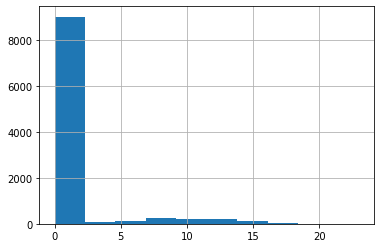

In [179]:
ch['num_direct_reports'].hist()

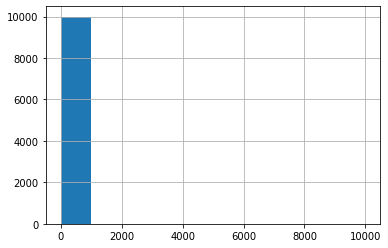

In [224]:
ch['num_indirect_reports'].hist()

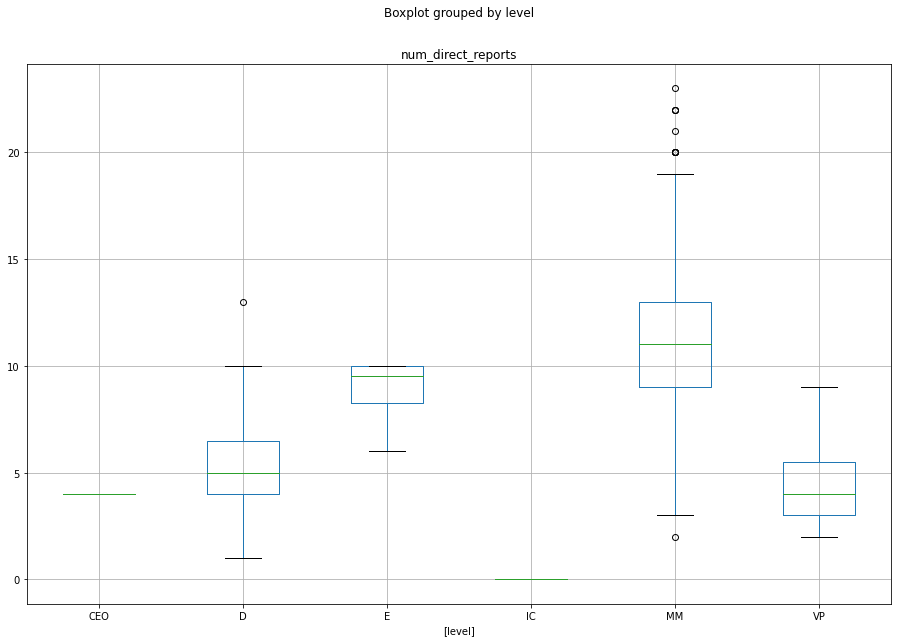

In [220]:
ch[['level', 'num_direct_reports']].boxplot(by='level', figsize=(15, 10))

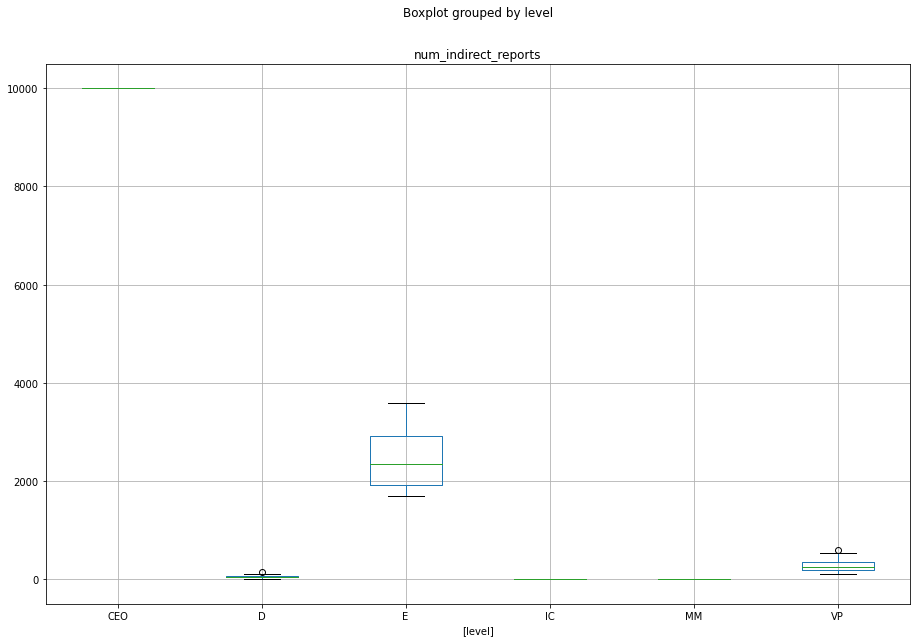

In [225]:
ch[['level', 'num_indirect_reports']].boxplot(by='level', figsize=(15, 10))

In [226]:
ch.groupby('level')['num_direct_reports'].describe()

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
CEO,1.0,4.000000,NaN,4.0,4.00,4.0,4.0,4.0
D,159.0,5.031447,2.094058,1.0,4.00,5.0,6.5,13.0
E,4.0,8.750000,1.892969,6.0,8.25,9.5,10.0,10.0
IC,9001.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
MM,800.0,11.250000,3.292195,2.0,9.00,11.0,13.0,23.0
VP,35.0,4.542857,1.804290,2.0,3.00,4.0,5.5,9.0


In [227]:
ch.groupby('level')['num_indirect_reports'].describe()

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
CEO,1.0,9994.000000,NaN,9994.0,9994.0,9994.0,9994.00,9994.0
D,159.0,56.603774,24.262546,5.0,40.5,54.0,72.50,153.0
E,4.0,2489.750000,842.643608,1686.0,1921.5,2342.5,2910.75,3588.0
IC,9001.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
MM,800.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
VP,35.0,280.000000,123.404405,109.0,190.0,250.0,343.50,599.0


In [251]:
ch.sort_values(by='num_indirect_reports', ascending=False)

,employee_id,boss_id,dept,level,num_direct_reports,num_indirect_reports
employee_id,,,,,,
61554,61554,NaN,CEO,CEO,4.0,9994.0
11277,11277,61554.0,sales,E,10.0,3588.0
51535,51535,61554.0,engineering,E,10.0,2685.0
110464,110464,61554.0,marketing,E,9.0,2000.0
93708,93708,61554.0,HR,E,6.0,1686.0
...,...,...,...,...,...,...
87625,87625,142104.0,engineering,IC,0.0,0.0
185166,185166,177495.0,HR,IC,0.0,0.0
153655,153655,184236.0,HR,IC,0.0,0.0


In [360]:
m = pd.merge(ch.drop('employee_id', axis=1), emp, on='employee_id', how='outer')
m

,boss_id,dept,level,num_direct_reports,num_indirect_reports,signing_bonus,salary,degree_level,sex,yrs_experience
employee_id,,,,,,,,,,
46456,175361.0,sales,IC,0.0,0.0,0,213000.0,Bachelor,M,5
104708,29733.0,HR,IC,0.0,0.0,0,79000.0,Bachelor,F,3
120853,41991.0,sales,IC,0.0,0.0,0,199000.0,High_School,M,5
142630,171266.0,HR,MM,16.0,0.0,0,143000.0,PhD,F,13
72711,198240.0,sales,IC,0.0,0.0,0,235000.0,Master,M,1
...,...,...,...,...,...,...,...,...,...,...
45022,154703.0,engineering,IC,0.0,0.0,0,185000.0,Master,M,3
173414,171461.0,HR,IC,0.0,0.0,0,70000.0,Bachelor,F,1
194688,161727.0,engineering,IC,0.0,0.0,0,346000.0,High_School,M,2


# EDA

In [383]:
m[m['salary'] > 4e5]

,boss_id,dept,level,num_direct_reports,num_indirect_reports,signing_bonus,salary,degree_level,sex,yrs_experience
employee_id,,,,,,,,,,
110464,61554.0,marketing,E,9.0,2000.0,1,550000.0,Master,M,21
11277,61554.0,sales,E,10.0,3588.0,1,550000.0,Master,M,22
61554,nan,CEO,CEO,4.0,9994.0,1,700000.0,PhD,M,7
51535,61554.0,engineering,E,10.0,2685.0,1,650000.0,PhD,M,33
93708,61554.0,HR,E,6.0,1686.0,1,500000.0,PhD,F,28


In [384]:
# Drop the top 5 salaries because they are outliers
m = m[m['salary'] < 4e5]

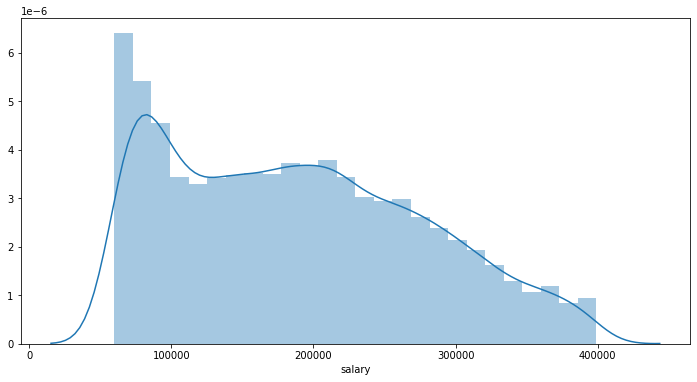

In [385]:
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(m['salary'], ax=ax)

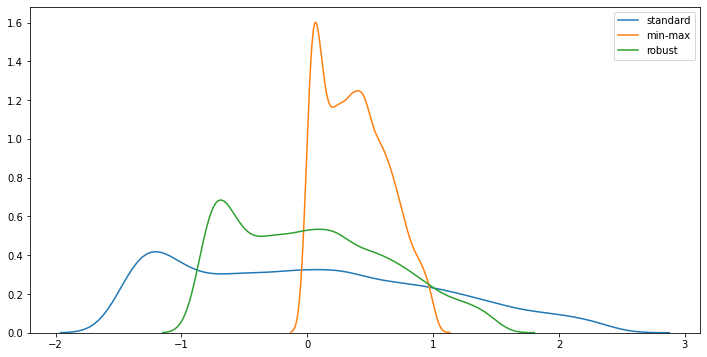

In [386]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(StandardScaler().fit_transform(m[['salary']].values), label='standard', hist=False, ax=ax)
sns.distplot(MinMaxScaler().fit_transform(m[['salary']].values), label='min-max', hist=False, ax=ax)
sns.distplot(RobustScaler().fit_transform(m[['salary']].values), label='robust', hist=False, ax=ax)

In [448]:
def get_types(df):
    dtypes = defaultdict(list)
    for col, dtype in df.dtypes.items():
        dtypes[str(dtype)].append(col)
    return dtypes

dtypes = get_types(m)
dtypes

defaultdict(list,
            {'object': ['boss_id', 'dept', 'level', 'degree_level', 'sex'],
             'float64': ['num_direct_reports',
              'num_indirect_reports',
              'salary'],
             'bool': ['signing_bonus'],
             'int64': ['yrs_experience']})

In [432]:
m['degree_level'].unique()

array(['Bachelor', 'High_School', 'PhD', 'Master'], dtype=object)

In [443]:
m['dept'].unique().tolist()

['sales', 'HR', 'engineering', 'marketing']

In [446]:
m['level'].unique()

array(['IC', 'MM', 'VP', 'D'], dtype=object)

In [451]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder

degree_level = ['High_School', 'Bachelor', 'Master', 'PhD']
dept = m['dept'].unique().tolist()
level = ['IC', 'MM', 'D', 'VP']

ordered = ['degree_level', 'dept', 'level']

m['boss_id'] = m['boss_id'].astype(str)
m['signing_bonus'] = m['signing_bonus'].astype(np.int8)
m['sex'] = m['signing_bonus'].astype(np.int8)

other = ['signing_bonus', 'sex']
to_scale = dtypes['int64'] + dtypes['float64']

transformer = ColumnTransformer([
    ('ordered', OrdinalEncoder(categories=[degree_level, dept, level]), ordered),
    ('other', FunctionTransformer(lambda x: x), other),    
    ('min-max', StandardScaler(), to_scale)
])

transformer = transformer.fit(m)
m_scaled = transformer.transform(m)
m_scaled = pd.DataFrame(m_scaled, columns=ordered + other + to_scale)
m_scaled[to_scale] = m_scaled[to_scale].astype(np.float64)

/opt/conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [453]:
m_scaled

,degree_level,dept,level,signing_bonus,sex,yrs_experience,num_direct_reports,num_indirect_reports,salary
0,1.0,0.0,0.0,0.0,0.0,0.368811,-0.306634,-0.096102,0.272118
1,1.0,1.0,0.0,0.0,0.0,-0.281669,-0.306634,-0.096102,-1.241609
2,0.0,0.0,0.0,0.0,0.0,0.368811,-0.306634,-0.096102,0.113967
3,3.0,1.0,1.0,0.0,0.0,2.970731,4.617243,-0.096102,-0.518635
4,2.0,0.0,0.0,0.0,0.0,-0.932149,-0.306634,-0.096102,0.520640
...,...,...,...,...,...,...,...,...,...
9990,2.0,2.0,0.0,0.0,0.0,-0.281669,-0.306634,-0.096102,-0.044183
9991,1.0,1.0,0.0,0.0,0.0,-0.932149,-0.306634,-0.096102,-1.343277
9992,0.0,2.0,0.0,0.0,0.0,-0.606909,-0.306634,-0.096102,1.774548
9993,0.0,2.0,0.0,1.0,1.0,-0.932149,-0.306634,-0.096102,1.300096


In [1]:
def correlation_heatmap(df, target=None, n_largest=None):
    f, ax = plt.subplots(figsize=(12, 9))
    # evidence for using both Kendall's Tau and Spearman's rho if the feature distributions are not
    # assumed to be normal: https://stats.stackexchange.com/questions/3943/kendall-tau-or-spearmans-rho
    # Some commenters say that Spearman's rho is more intepretable because it extends the idea of R^
    # in that it quantifies the difference between the % of concordant and discordant pairs among all
    # possible pairwise events.
    corrmat = df.corr(method='spearman')
    if n_largest is not None:
        cols = corrmat.nlargest(n_largest, target)  [target].index
        cm = np.corrcoef(df[cols].values.T)
        sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                    xticklabels=cols.values)
    else:
        cols = []
        sns.heatmap(corrmat, vmax=.8, square=True)

    return cols


target = 'salary'
correlation_heatmap(m_scaled[to_scale], target)

NameError: name 'm_scaled' is not defined

In [478]:
m_scaled[to_scale].corr(method='spearman')['salary']

yrs_experience          0.015220
num_direct_reports      0.032906
num_indirect_reports    0.050986
salary                  1.000000
Name: salary, dtype: float64

In [695]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(x):
    x_matrix = x.values
    vif = [variance_inflation_factor(x_matrix, i) for i in range(x_matrix.shape[1])]
    vif_factors = pd.DataFrame()
    vif_factors['column'] = x.columns
    vif_factors['vif'] = vif
    return vif_factors.sort_values(by=['vif'], ascending=False)[0:10]
    
get_vif(m_scaled)

,column,vif
3,signing_bonus,inf
4,sex,inf
2,level,5.971025
6,num_direct_reports,3.262255
7,num_indirect_reports,2.133345
0,degree_level,2.040595
1,dept,1.848153
5,yrs_experience,1.761228
8,salary,1.024847


In [694]:
get_vif(m_scaled.drop(['signing_bonus', 'sex'], axis=1))

,column,vif
2,level,5.927621
4,num_direct_reports,3.259971
5,num_indirect_reports,2.127684
0,degree_level,1.931319
1,dept,1.789875
3,yrs_experience,1.761267
6,salary,1.019501


/opt/conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


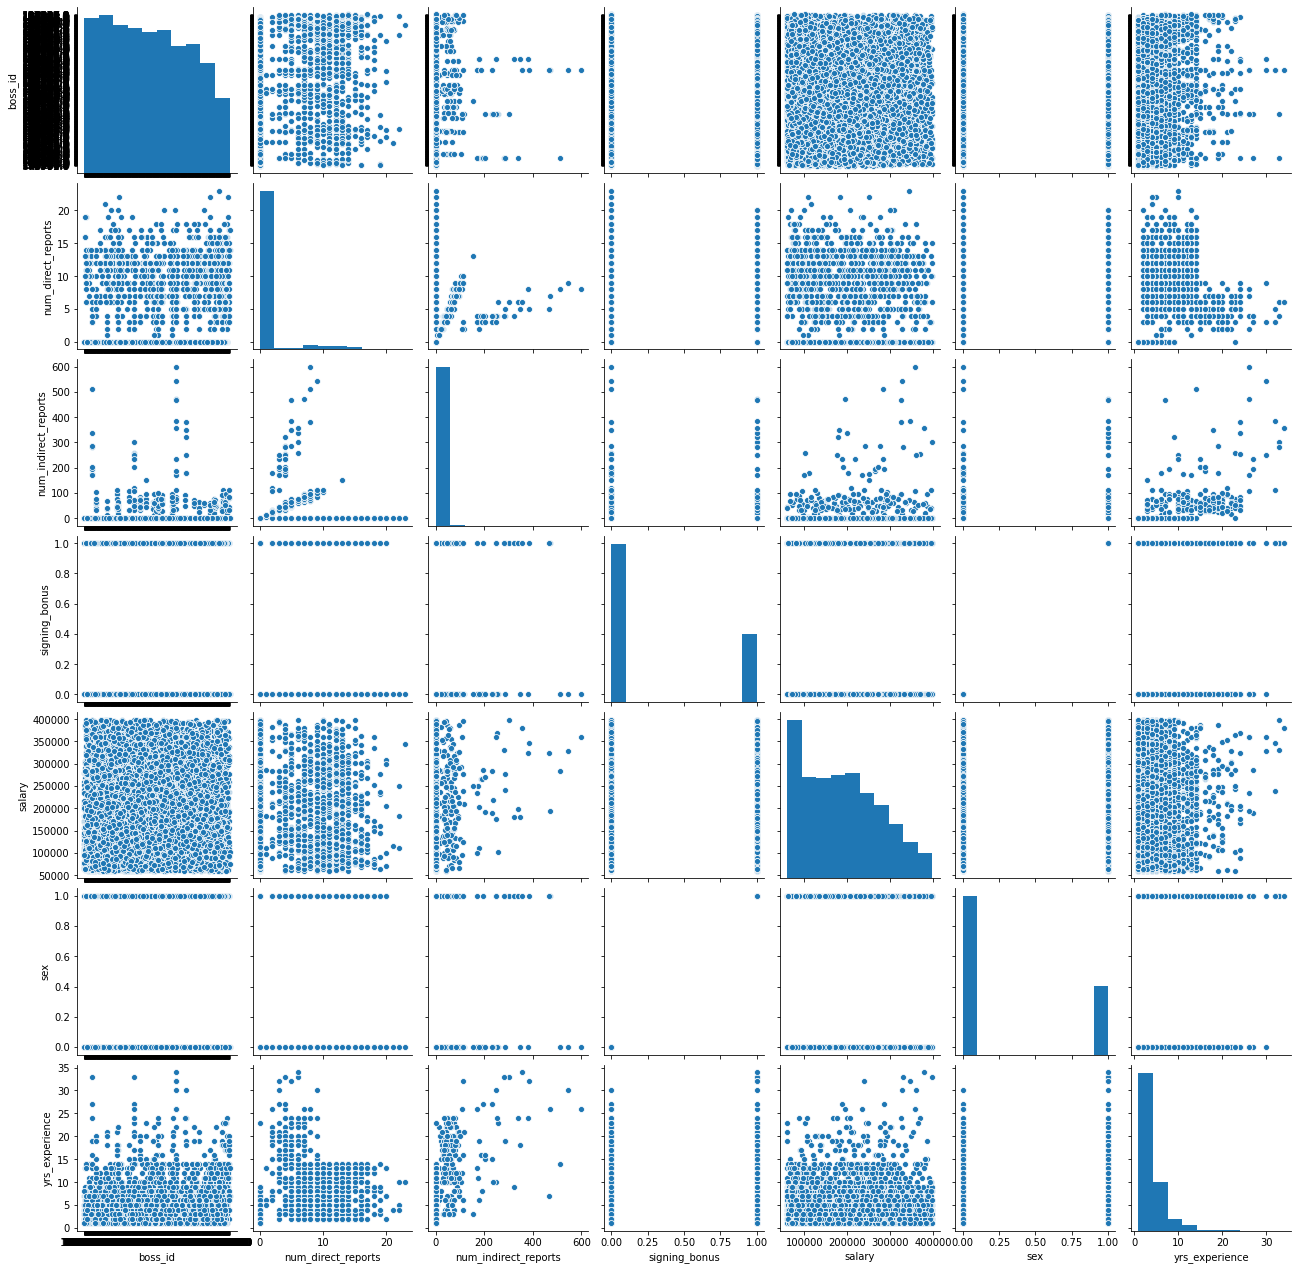

In [457]:
def pairplot(df, cols):
    sns.pairplot(df[cols], size=2.5)

m['signing_bonus'] = m['signing_bonus'].astype(np.int64)
pairplot(m, m.columns)

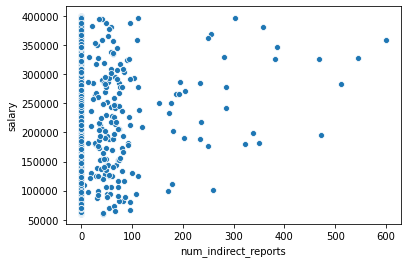

In [496]:
sns.scatterplot(x='num_indirect_reports', y='salary', data=m)

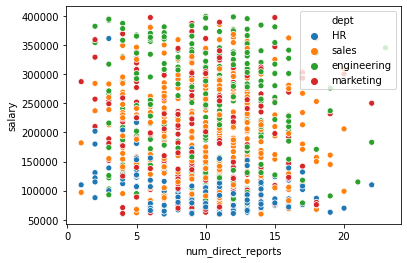

In [481]:
sns.scatterplot(x='num_direct_reports', y='salary', hue='dept', data=m[m['level'] != 'IC'])

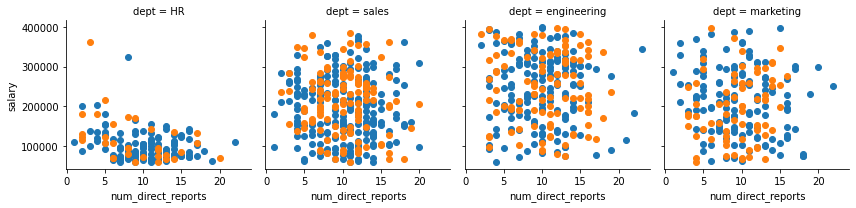

In [488]:
grid = sns.FacetGrid(data=m[m['level'] != 'IC'], col='dept', hue='sex', col_wrap=4)
grid = grid.map(plt.scatter, 'num_direct_reports', 'salary')

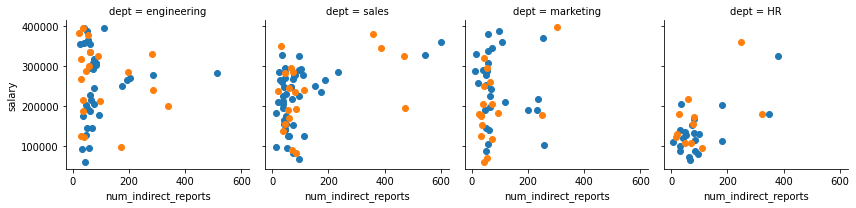

In [491]:
grid = sns.FacetGrid(data=m[~m['level'].isin(['IC', 'MM'])], col='dept', hue='sex', col_wrap=4)
grid = grid.map(plt.scatter, 'num_indirect_reports', 'salary')

In [646]:
m

,boss_id,dept,level,num_direct_reports,num_indirect_reports,signing_bonus,salary,degree_level,sex,yrs_experience
employee_id,,,,,,,,,,
46456,175361.0,sales,IC,0.0,0.0,0,213000.0,Bachelor,0,5
104708,29733.0,HR,IC,0.0,0.0,0,79000.0,Bachelor,0,3
120853,41991.0,sales,IC,0.0,0.0,0,199000.0,High_School,0,5
142630,171266.0,HR,MM,16.0,0.0,0,143000.0,PhD,0,13
72711,198240.0,sales,IC,0.0,0.0,0,235000.0,Master,0,1
...,...,...,...,...,...,...,...,...,...,...
45022,154703.0,engineering,IC,0.0,0.0,0,185000.0,Master,0,3
173414,171461.0,HR,IC,0.0,0.0,0,70000.0,Bachelor,0,1
194688,161727.0,engineering,IC,0.0,0.0,0,346000.0,High_School,0,2


In [661]:
m['count'] = 1


/opt/conda/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,dept,variable,value
0,sales,sex,0
1,HR,sex,0
2,sales,sex,0
3,HR,sex,0
4,sales,sex,0
...,...,...,...
9990,engineering,sex,0
9991,HR,sex,0
9992,engineering,sex,0
9993,engineering,sex,1


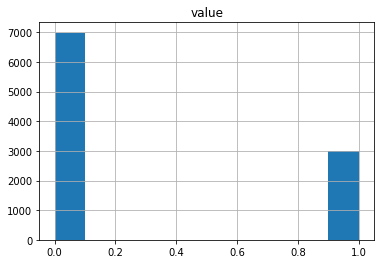

In [655]:
melt = m.melt(id_vars=['dept'], value_vars=['sex'])
melt[['dept', 'value']].hist()
melt

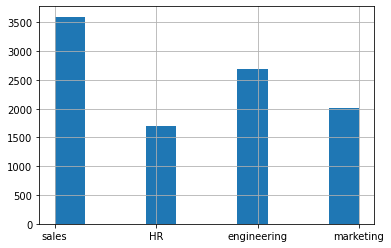

In [644]:
m['dept'].hist()

In [ ]:
# relationship between salary and direct reports, indirect reports, yrs_experience? 

In [401]:
m_scaled

,boss_id,dept,level,degree_level,sex,signing_bonus,yrs_experience,num_direct_reports,num_indirect_reports,salary
0,410.0,3.0,1.0,0.0,1.0,0.0,0.368811,-0.306634,-0.096102,0.272118
1,605.0,0.0,1.0,0.0,0.0,0.0,-0.281669,-0.306634,-0.096102,-1.241609
2,657.0,3.0,1.0,1.0,1.0,0.0,0.368811,-0.306634,-0.096102,0.113967
3,387.0,0.0,2.0,3.0,0.0,0.0,2.970731,4.617243,-0.096102,-0.518635
4,543.0,3.0,1.0,2.0,1.0,0.0,-0.932149,-0.306634,-0.096102,0.520640
...,...,...,...,...,...,...,...,...,...,...
9990,295.0,1.0,1.0,2.0,1.0,0.0,-0.281669,-0.306634,-0.096102,-0.044183
9991,389.0,0.0,1.0,0.0,0.0,0.0,-0.932149,-0.306634,-0.096102,-1.343277
9992,330.0,1.0,1.0,1.0,1.0,0.0,-0.606909,-0.306634,-0.096102,1.774548
9993,854.0,1.0,1.0,1.0,0.0,1.0,-0.932149,-0.306634,-0.096102,1.300096


In [691]:
from sklearn.feature_selection import f_regression

# degree_level is not significant
# level, signing_bonus, sex, dept are significant
f, p = f_regression(m_scaled[ordered + other], m['salary'])
pd.DataFrame({'f': f, 'p': p, 'columns': ordered + other}).sort_values(by='f')

,f,p,columns
0,1.722687,1.893776e-01,degree_level
2,25.488985,4.527616e-07,level
3,106.815091,6.522774e-25,signing_bonus
4,106.815091,6.522774e-25,sex
1,219.123157,4.640073e-49,dept


In [696]:
f, p = f_regression(m_scaled[ordered + other], m['sex'])
pd.DataFrame({'f': f, 'p': p, 'columns': ordered + other}).sort_values(by='f')

,f,p,columns
3,-1.022829e+18,1.000000,signing_bonus
4,-1.022829e+18,1.000000,sex
0,4.911698e-03,0.944129,degree_level
2,5.442189e+00,0.019676,level
1,2.108732e+01,0.000004,dept


In [586]:
from sklearn.linear_model import LinearRegression

x = m_scaled.drop('salary', axis=1)
x_columns = x.columns
y = m['salary']

In [587]:
def get_bins(y, n_bins):
    percentiles = np.percentile(y, np.linspace(0, 100, n_bins))
    return percentiles, np.searchsorted(percentiles[1:-1], y)

percentiles, bins = get_bins(y, 5)
percentiles

array([ 60000., 110000., 182000., 255000., 399000.])

In [588]:
bins = pd.Series(bins)
bins.index = m.index 
x.index = bins.index

In [601]:
splitter = bins.astype(str) + '_' + x['sex'].astype(str)
splitter

employee_id
46456     2_0.0
104708    0_0.0
120853    2_0.0
142630    1_0.0
72711     2_0.0
          ...  
45022     2_0.0
173414    0_0.0
194688    3_0.0
11698     3_1.0
144338    0_0.0
Length: 9995, dtype: object

In [610]:
xtrain_all, xtest, ytrain_all, ytest = train_test_split(x, y.values, test_size=.2, stratify=splitter)

xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_all, ytrain_all, test_size=.25, 
                                                    stratify=splitter.loc[xtrain_all.index])

In [619]:
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(xtrain, ytrain)
mse = mean_squared_error(yvalid, lr.predict(xvalid), squared=False)
mse

87257.73534604505

In [614]:
from xgboost import XGBRegressor

regressor = XGBRegressor().fit(xtrain, ytrain)
mse = mean_squared_error(yvalid, regressor.predict(xvalid), squared=False)
mse

74677.97823520993

In [ ]:
regressor.feature

In [618]:
pd.DataFrame({'importance': regressor.feature_importances_, 'feature': x_columns}).sort_values(by='importance')

,importance,feature
4,0.000000,sex
3,0.024840,signing_bonus
2,0.025427,level
0,0.027167,degree_level
5,0.029488,yrs_experience
6,0.030839,num_direct_reports
7,0.032324,num_indirect_reports
1,0.829915,dept


In [677]:
m.groupby(['dept','sex']).count()['count'] / m.groupby(['dept']).count()['count'] 

dept         sex
HR           0      0.870053
             1      0.129947
engineering  0      0.609647
             1      0.390353
marketing    0      0.690393
             1      0.309607
sales        0      0.690106
             1      0.309894
Name: count, dtype: float64

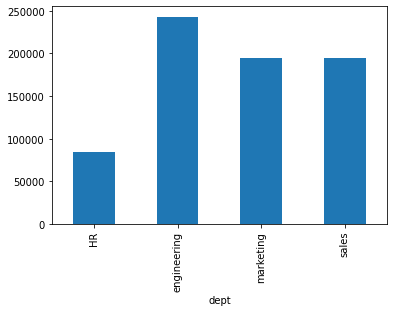

In [710]:
m.groupby(['dept']).mean()['salary'].plot(kind='bar')

In [703]:
means = m.groupby(['dept', 'level', 'yrs_experience']).mean().reset_index()
means['level'] = pd.Categorical(means['level'], ['IC', 'MM', 'D', 'VP'])
means

,dept,level,yrs_experience,num_direct_reports,num_indirect_reports,signing_bonus,salary,sex,count
0,HR,D,3,4.500000,44.500000,0.000000,165500.000000,0.000000,1.0
1,HR,D,5,4.666667,45.666667,0.000000,83000.000000,0.000000,1.0
2,HR,D,7,2.000000,20.000000,1.000000,131000.000000,1.000000,1.0
3,HR,D,8,5.250000,63.750000,0.500000,130000.000000,0.500000,1.0
4,HR,D,11,5.500000,64.000000,0.000000,109500.000000,0.000000,1.0
5,HR,D,12,5.000000,69.500000,0.500000,91500.000000,0.500000,1.0
6,HR,D,15,3.000000,33.000000,0.000000,100000.000000,0.000000,1.0
7,HR,D,16,4.000000,42.000000,0.000000,120000.000000,0.000000,1.0
8,HR,D,17,5.666667,62.333333,0.666667,175333.333333,0.666667,1.0
9,HR,D,18,4.500000,55.500000,0.500000,148000.000000,0.500000,1.0


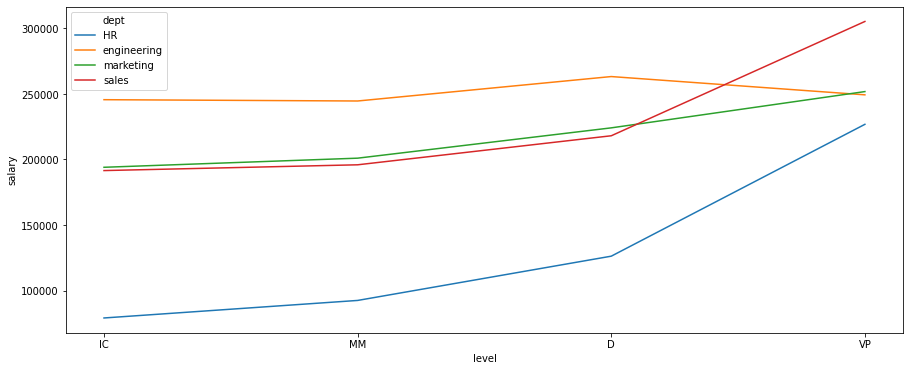

In [723]:
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=means, x='level', y='salary', hue='dept', ax=ax, err_style=None)

In [729]:
means = m.groupby(['dept', 'sex']).count().reset_index()
means

,dept,sex,boss_id,level,num_direct_reports,num_indirect_reports,signing_bonus,salary,degree_level,yrs_experience,count
0,HR,0,1473,1473,1473,1473,1473,1473,1473,1473,1473
1,HR,1,220,220,220,220,220,220,220,220,220
2,engineering,0,1643,1643,1643,1643,1643,1643,1643,1643,1643
3,engineering,1,1052,1052,1052,1052,1052,1052,1052,1052,1052
4,marketing,0,1387,1387,1387,1387,1387,1387,1387,1387,1387
5,marketing,1,622,622,622,622,622,622,622,622,622
6,sales,0,2483,2483,2483,2483,2483,2483,2483,2483,2483
7,sales,1,1115,1115,1115,1115,1115,1115,1115,1115,1115


AttributeError: 'Rectangle' object has no property 'err_style'

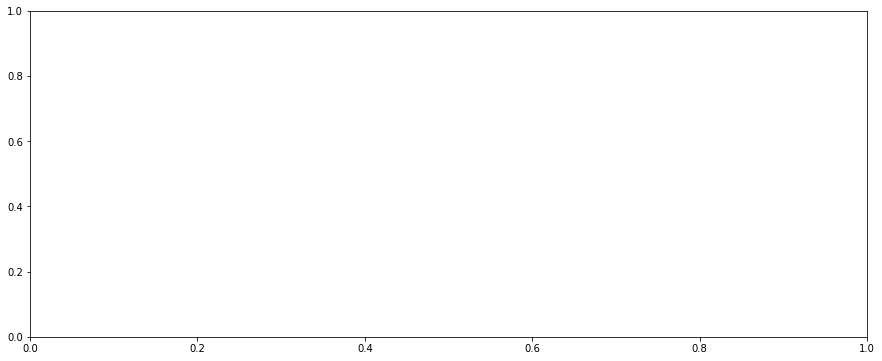

In [731]:
f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(data=means, x='dept', y='salary', hue='sex', ax=ax, err_style=None)

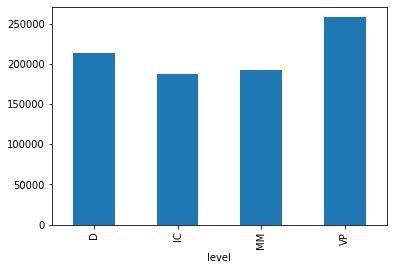

In [712]:
m.groupby(['level']).mean()['salary'].plot(kind='bar')

In [724]:
def class_hists(data, column, target, bins="auto", ax=None, legend=True,
                scale_separately=True):
    """
    Grouped univariate histograms by categorical target.

    From dabl: https://github.com/dabl/dabl/blob/a333bd7/dabl/plot/utils.py#L487

    Parameters
    ----------
    data : pandas DataFrame
        Input data to plot.
    column : column specifier
        Column in the data to compute histograms over (must be continuous).
    target : column specifier
        Target column in data, must be categorical.
    bins : string, int or array-like
        Number of bins, 'auto' or bin edges. Passed to np.histogram_bin_edges.
        We always show at least 5 bins for now.
    ax : matplotlib axes
        Axes to plot into.
    legend : boolean, default=True
        Whether to create a legend.
    scale_separately : boolean, default=True
        Whether to scale each class separately.
    Examples
    --------
    >>> class_hists(data, "age", "gender", legend=True)
    <matplotlib...
    """
    col_data = data[column].dropna()

    if ax is None:
        ax = plt.gca()
    if col_data.nunique() > 10:
        ordinal = False
        # histograms
        hist, bin_edges = np.histogram(col_data, bins=bins)
        if len(bin_edges) > 30:
            hist, bin_edges = np.histogram(col_data, bins=30)

        counts = {}
        for name, group in data.groupby(target)[column]:
            this_counts, _ = np.histogram(group, bins=bin_edges)
            counts[name] = this_counts
        counts = pd.DataFrame(counts)
    else:
        ordinal = True
        # ordinal data, count distinct values
        counts = data.groupby(target)[column].value_counts().unstack(target)
    if scale_separately:
        # normalize by maximum
        counts = counts / counts.max()
    bottom = counts.max().max() * 1.1
    for i, name in enumerate(counts.columns):
        if ordinal:
            ax.bar(range(counts.shape[0]), counts[name], width=.9,
                   bottom=bottom * i, tick_label=counts.index, linewidth=2,
                   edgecolor='k', label=name)
            xmin, xmax = 0 - .5, counts.shape[0] - .5
        else:
            ax.bar(bin_edges[:-1], counts[name], bottom=bottom * i, label=name,
                   align='edge', width=(bin_edges[1] - bin_edges[0]) * .9)
            xmin, xmax = bin_edges[0], bin_edges[-1]
        ax.hlines(bottom * i, xmin=xmin, xmax=xmax,
                  linewidth=1)
    if legend:
        ax.legend()
    ax.set_yticks(())
    ax.set_xlabel(column)
    return ax

In [632]:
accuracy_pct = pd.Series((regressor.predict(xvalid) / yvalid  - 1)).abs()
accuracy_25pct = (accuracy_pct < .25).mean()

print("We are within 25% of the actual salary in ",  accuracy_25pct.round(2)*100, "% of the cases", sep="")

We are within 25% of the actual salary in 50.0% of the cases


In [683]:
x = m_scaled.drop(['salary', 'sex'], axis=1)
x.index = m.index
x_columns = x.columns
y = m['salary']
splitter = bins.astype(str) + '_' + x['dept'].astype(str)

xtrain_all, xtest, ytrain_all, ytest = train_test_split(x, y.values, test_size=.2, stratify=splitter)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_all, ytrain_all, test_size=.25, 
                                                    stratify=splitter.loc[xtrain_all.index])
regressor = XGBRegressor().fit(xtrain, ytrain)
mse = mean_squared_error(yvalid, regressor.predict(xvalid), squared=False)
mse

74391.72644560618

In [682]:
pd.DataFrame({'importance': regressor.feature_importances_, 'feature': x_columns}).sort_values(by='importance')

,importance,feature
4,0.029430,yrs_experience
3,0.029726,signing_bonus
6,0.030234,num_indirect_reports
5,0.030489,num_direct_reports
2,0.030981,level
0,0.032246,degree_level
1,0.816894,dept


In [686]:
!pip install pdpbox

     |████████████████████████████████| 57.7 MB 26.8 MB/s eta 0:00:01
  Created wheel for pdpbox: filename=PDPbox-0.2.0-py3-none-any.whl size=57690722 sha256=81ba7f7aa70446f1a5025ab64bc51ad03e1a035ee7408f9cf1fb5a3cb50f8b10
  Stored in directory: /root/.cache/pip/wheels/23/d4/d0/7c7a2adaab2fa7c7108e86c0eb7272fa8e2cd0b6b6732d2e15
Successfully built pdpbox


In [689]:
from pdpbox import pdp, info_plots
  
#dept
pdp_iso = pdp.pdp_isolate(model=regressor, 
                          dataset=x,
                          model_features=x_columns, 
                          feature=['dept'], 
                          num_grid_points=50)
pdp_dataset = pandas.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Partial Plot for Dept')
plt.show()

ValueError: one-hot encoding feature should contain more than 1 element